In [16]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import scipy
from scipy import integrate

In [17]:
# Collect data from file
def collect_data_float(filename):
    with open(filename) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        # Change strings to floats
        lines = [float(x) for x in lines]
    return lines



In [18]:
data = collect_data_float('datafile-exp.txt')

In [19]:
print(data[0])
print(len(data))
print(type(data[0]))

4.30037022522614
10000
<class 'float'>


In [20]:
# Convert the data to float, as currently its in string
# That has been put into the function to make sure I dont have to repeat code later
#data = [float(x) for x in data]

In [21]:
print(type(data[0]))

<class 'float'>


In [22]:
def hist(data, title):
    
    # Plot histograms
    plt.figure(figsize=(10,10))
    plt.hist(data, bins = 100)
        
    plt.title("Histogram of " + str(title))
    #plt.savefig(str(data_type[Type]) + '_Full_Histogram.pdf')
    plt.show()

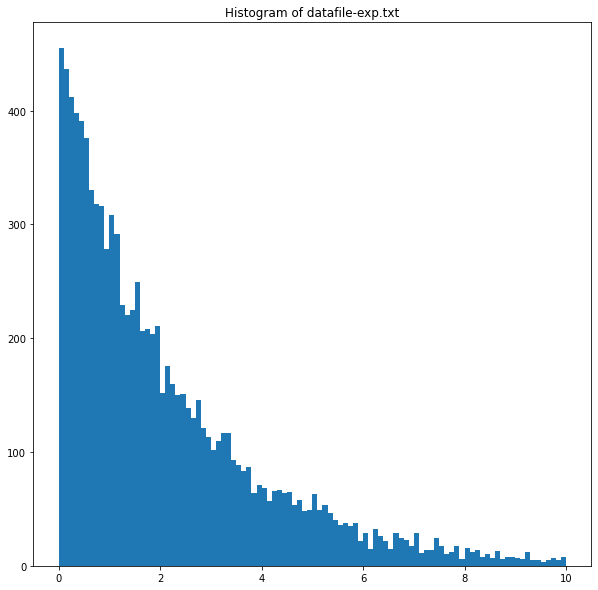

In [23]:
hist(data, "datafile-exp.txt")

In [24]:
# Maximum likelihood fit

# Define the exponential
def exponential(x, lifetime):
    y = (1/lifetime) * np.exp(-x/lifetime)
    return y
    

# Define the maximum likelihood fitting method
def nll(lifetime):
    
    # Create list
    y = []
    
    # Give data points
    x = data
    counter = 0
    # loop to collect all y values
    for i in range(len(x)):
        #print(x[i], lifetime)
        y_i = exponential(x[i], lifetime)
        #print(y_i)
        l_y_i = np.log(y_i)
        y.append(y_i)

        
    
    # Normalise
        
    # integrate over our range for the linear
    y_new, err_new = scipy.integrate.quad(exponential, 0, 10, args = (lifetime))
    # Normalise y values
    y_norm = [i / y_new for i in y]
        
    # nll
    nll = -np.sum(y_norm)
    
    return nll

In [25]:
# Taken from the notes from last week to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')


In [26]:
m = Minuit(nll, lifetime = 3)
m.errors = 0.5
m.errordef = 0.5

# Fit and show results
result = m.migrad()

showIminuitResult(("lifetime",), m)

/tmp/ipykernel_85886/1661381024.py:23: RuntimeWarning: invalid value encountered in log
  l_y_i = np.log(y_i)
/tmp/ipykernel_85886/1661381024.py:5: RuntimeWarning: overflow encountered in exp
  y = (1/lifetime) * np.exp(-x/lifetime)
/tmp/ipykernel_85886/1661381024.py:5: RuntimeWarning: overflow encountered in double_scalars
  y = (1/lifetime) * np.exp(-x/lifetime)
/tmp/ipykernel_85886/1661381024.py:33: RuntimeWarning: invalid value encountered in double_scalars
  y_norm = [i / y_new for i in y]


	 lifetime        :  	   0.0529  +/-    0.0032




In [12]:
del data